In [1]:
import pandas as pd
from transformers import RobertaModel, RobertaTokenizer, RobertaConfig
from triagerx.dataset.text_processor import TextProcessor

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/data/deeptriage/google_chrome/classifier_data_20.csv"
df = pd.read_csv(dataset_path)
df = df.rename(columns={"assignees": "owner", "issue_body": "description"})
df = df[df["owner"].notna()]

num_cv = 10
block = 9
# sample_threshold=20 # Threshold to filter developers
samples_per_block = len(df) // num_cv

sliced_df = df[: samples_per_block * (block + 1)]
df_train = sliced_df[: samples_per_block * block]
df_test = sliced_df[samples_per_block * block : samples_per_block * (block + 1)]

sample_threshold = 20
developers = df_train["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
df_train = df_train[df_train["owner"].isin(filtered_developers)]

train_owners = set(df_train["owner"])
test_owners = set(df_test["owner"])

unwanted = list(test_owners - train_owners)

df_test = df_test[~df_test["owner"].isin(unwanted)]

lbl2idx = {}
idx2lbl = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx
    idx2lbl[idx] = dev

df_train["owner_id"] = df_train["owner"].apply(lambda owner: lbl2idx[owner])
df_test["owner_id"] = df_test["owner"].apply(lambda owner: lbl2idx[owner])
df_test = TextProcessor.prepare_dataframe(df_test, False, False, True, False, False)

print(f"Training data: {len(df_train)}, Validation data: {len(df_test)}")
print(f"Number of train developers: {len(df_train.owner.unique())}")
print(f"Number of test developers: {len(df_test.owner.unique())}")

100%|██████████| 10781/10781 [00:00<00:00, 1130922.15it/s]
2024-07-10 09:30:31.999 | INFO     | triagerx.dataset.text_processor:prepare_dataframe:58 - Cleaning text...
100%|██████████| 10781/10781 [00:01<00:00, 5660.42it/s]
2024-07-10 09:30:33.909 | INFO     | triagerx.dataset.text_processor:prepare_dataframe:71 - Adding description...
100%|██████████| 10781/10781 [00:00<00:00, 125238.99it/s]

Training data: 98165, Validation data: 10781
Number of train developers: 986
Number of test developers: 857


In [4]:
df_test.iloc[100].text

'Bug Title: Allow canvases on background pages to have their GPU resources evicted\nBug Description: In order to reduce the probability of canvas-based apps losing data due to GPU context losses and to prevent slow-downs caused by GPU resource strain, canvases should be swapped-out from GPU memory when the host page becomes hidden.'

In [5]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import numpy as np

class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: RobertaTokenizer,
        feature: str = "text",
        target: str = "owner_id",
        max_tokens: int = 256,
    ):
        print("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        print("Tokenizing texts...")
        self.texts = [
            self.tokenizer(
                row[feature],
                padding="max_length",
                max_length=max_tokens,
                truncation=True,
                return_tensors="pt",
            )
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [6]:
import numpy as np
import pandas as pd
from loguru import logger
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel
from triagerx.dataset.text_processor import TextProcessor


def process_data_for_triagerx(
        text,
        model: PredictionModel,
        max_length: int = 256,
        device="cuda"
    ):
        
        text = TextProcessor.clean_text(text)

        tokenizer1 = model.tokenizer(0)
        tokenizer2 = model.tokenizer(1)

        tok1 = tokenizer1(
                    text,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )
        
        input_ids1 = tok1["input_ids"].to(device)
        mask1 = tok1["attention_mask"].to(device)
        
        
        tok2 = tokenizer2(
                    text,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )
        
        input_ids2 = tok2["input_ids"].to(device)
        mask2 = tok2["attention_mask"].to(device)

        return input_ids1, mask1, input_ids2, mask2


In [7]:
import torch
import torch.nn as nn

device="cuda"

class LBTPClassifier(nn.Module):
    def __init__(
        self,
        embedding_model,
        output_size,
        unfrozen_layers=1,
        num_classifiers=3,
        max_tokens=256,
    ) -> None:
        super().__init__()
        self.base_model = embedding_model

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till last {unfrozen_layers} layers
        for i in range(0, self.base_model.config.num_hidden_layers - unfrozen_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = max_tokens
        self._num_classifiers = num_classifiers
        self._embed_size = embedding_model.config.hidden_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, self._embed_size)),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(self._num_classifiers)
            ]
        )

        self.classifier_weights = nn.Parameter(torch.ones(self._num_classifiers))

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(
                    len(filter_sizes) * self._num_filters + self._embed_size,
                    output_size,
                )
                for _ in range(self._num_classifiers)
            ]
        )

        # Dropout is ommitted as it is not mentioned in the LBTP paper
        # self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None):
        # input_ids = input["input_ids"].squeeze(1).to(device)
        # attention_mask = input["attention_mask"].squeeze(1).to(device)

        outputs = []

        base_out = self.base_model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)

        # print(base_out.attentions)
        
        pooler_out = base_out.pooler_output.squeeze(0)
        
        if len(pooler_out.shape) == 1:
            pooler_out = pooler_out.unsqueeze(0)
            
        hidden_states = base_out.hidden_states[-self._num_classifiers :]

        for i in range(self._num_classifiers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]  
            x = torch.cat(x, dim=1)
            x = torch.cat([pooler_out, x], dim=1)
            x = self.classifier_weights[i] * self.classifiers[i](x)

            outputs.append(x)

        return outputs

In [8]:
print("Load pretrained embedding model")
model_config = RobertaConfig.from_pretrained("roberta-large")
model_config.num_hidden_layers = 3
model_config.output_hidden_states = True
embedding_model = RobertaModel(model_config)
embedding_model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/distillation/lbtp_gc_base.pt"))
print("Loaded weights from the saved state.")

tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

model = LBTPClassifier(embedding_model, output_size=len(df_train.owner_id.unique()))
model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/lbtp_dt_gc/lbtp_gc_block9.pt"))

Load pretrained embedding model
Loaded weights from the saved state.


<All keys matched successfully>

In [9]:
import torch
from loguru import logger
from torch import nn
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel


class TriagerxModel(PredictionModel):
    def __init__(
        self,
        output_size,
        unfrozen_layers,
        num_classifiers,
        base_models,
        dropout=0.1,
        max_tokens=512,
        num_filters=256,
        label_map=None,
    ) -> None:
        super(TriagerxModel, self).__init__()

        # Initialize base models and their respective tokenizers
        logger.debug(f"Loading base transformer models: {base_models}")
        self.base_models = nn.ModuleList(
            [
                AutoModel.from_pretrained(model, output_hidden_states=True)
                for model in base_models
            ]
        )
        self.tokenizers = [
            AutoTokenizer.from_pretrained(model) for model in base_models
        ]
        self._label_map = label_map

        if unfrozen_layers == -1:
            logger.debug("Initiating full training...")
        else:
            # Freeze embedding layers for all models
            for base_model in self.base_models:
                logger.debug(
                    f"Freezing {base_model.config.num_hidden_layers - unfrozen_layers} layers"
                )
                for p in base_model.embeddings.parameters():
                    p.requires_grad = False

            # Freeze encoder layers until the last `unfrozen_layers` layers for all models
            for base_model in self.base_models:
                for i in range(
                    0, base_model.config.num_hidden_layers - unfrozen_layers
                ):
                    for p in base_model.encoder.layer[i].parameters():
                        p.requires_grad = False

        # Define filter sizes for convolution layers
        filter_sizes = [3, 4, 5, 6]
        self._num_filters = num_filters
        self._num_classifiers = num_classifiers
        self._max_tokens = max_tokens
        self.unfrozen_layers = unfrozen_layers

        # Calculate total embedding size by summing hidden sizes of all base models
        embed_sizes = [base_model.config.hidden_size for base_model in self.base_models]
        self._embed_size = sum(embed_sizes)

        # Initialize convolutional blocks for each classifier
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(
                                1,
                                self._num_filters,
                                (K, self._embed_size),
                            ),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(self._num_classifiers)
            ]
        )

        # Initialize classifiers for each classifier block
        self.classifiers = nn.ModuleList(
            [
                nn.Linear(len(filter_sizes) * self._num_filters, output_size)
                for _ in range(self._num_classifiers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

        # Initialize learnable weights for each base model
        self.model_weights = nn.ParameterList(
            [nn.Parameter(torch.ones(self._num_classifiers)) for _ in self.base_models]
        )
        self.classifier_weights = nn.Parameter(torch.ones(self._num_classifiers))

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # Process input data for each base model
        # inputs = [
        #     {
        #         key: value.squeeze(1).to(next(self.parameters()).device)
        #         for key, value in model_inputs.items()
        #     }
        #     for model_inputs in inputs
        # ]

        hidden_states = []

        # Extract hidden states from each base model
        for idx, base_model in enumerate(self.base_models):
            ids = None
            mask = None

            if idx == 0:
                ids = input_ids1
                mask = attention_mask1

            if idx == 1:
                ids = input_ids2
                mask = attention_mask2


            base_out = base_model(
                input_ids=ids,
                attention_mask=mask,
            )
            hidden_states.append(base_out.hidden_states[-self._num_classifiers :])

        outputs = []

        # Concatenate hidden states and apply convolutional blocks and classifiers
        for i in range(self._num_classifiers):
            # Apply learnable weights to hidden states from each base model
            weighted_hidden_states = [
                self.model_weights[idx][i] * hidden_states[idx][i]
                for idx in range(len(self.base_models))
            ]
            concatenated_hidden_states = torch.cat(weighted_hidden_states, dim=-1)
            batch_size, sequence_length, hidden_size = concatenated_hidden_states.size()
            x = [
                conv(
                    concatenated_hidden_states.view(
                        batch_size, 1, sequence_length, hidden_size
                    )
                )
                for conv in self.conv_blocks[i]
            ]
            # Concatenating outputs of the convolutional blocks of different filter sizes
            x = torch.cat(x, dim=1)
            x = self.dropout(x)
            x = self.classifier_weights[i] * self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self, model_idx) -> PreTrainedTokenizer:
        # Return the tokenizer for the specified base model index
        if model_idx < 0 or model_idx >= len(self.tokenizers):
            raise ValueError(
                f"Invalid model index, choose between 0 and {len(self.tokenizers) - 1}"
            )
        return self.tokenizers[model_idx]

    def tokenize_text(self, text):
        return [
            tokenizer(
                text,
                padding="max_length",
                max_length=self._max_tokens,
                truncation=True,
                return_tensors="pt",
            )
            for tokenizer in self.tokenizers
        ]

    def get_label_map(self):
        return self._label_map


In [10]:
df_train.owner.unique()

array(['amit@chromium.org', 'jon@chromium.org', 'pfeldman@chromium.org',
       'pkasting@chromium.org', 'brettw@chromium.org',
       'darin@chromium.org', 'dcheng@chromium.org', 'mar...@chromium.org',
       'fsam...@chromium.org', 'rjkro...@chromium.org',
       'danakj@chromium.org', 'reve...@chromium.org',
       'yutak@chromium.org', 'dgarr...@chromium.org',
       'jamescook@chromium.org', 'rsesek@chromium.org',
       'bauerb@chromium.org', 'fmalita@chromium.org',
       'scherkus@chromium.org', 'achuith@chromium.org',
       'tkent@chromium.org', 'fbarchard@chromium.org', 'arv@chromium.org',
       'avayvod@chromium.org', 'timurrrr@chromium.org',
       'sky@chromium.org', 'wtc@chromium.org', 'erikwright@chromium.org',
       'semenzato@chromium.org', 'estade@chromium.org',
       'sgabr...@chromium.org', 'gbillock@chromium.org',
       'nkostylev@chromium.org', 'phajdan.jr@chromium.org',
       'marc...@chromium.org', 'gwilson@chromium.org',
       'derat@chromium.org', 'scot

In [11]:
len(df_train.owner.unique())

986

In [12]:
triagerx_model = TriagerxModel(
    output_size=len(df_train.owner.unique()),
    unfrozen_layers=3,
    num_classifiers=3,
    base_models=["microsoft/deberta-base", "roberta-base"],
    dropout=0.2,
    max_tokens=256,
    num_filters=256,
    label_map=None,
)

2024-07-10 09:30:36.704 | DEBUG    | __main__:__init__:24 - Loading base transformer models: ['microsoft/deberta-base', 'roberta-base']
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-07-10 09:30:38.274 | DEBUG    | __main__:__init__:41 - Freezing 9 layers
2024-07-10 09:30:38.276 | DEBUG    | __main__:__init__:41 - Freezing 9 layers


In [13]:
triagerx_model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/deeptriage/triagerx_ensemble_dt_gc_th20_block9_seed42.pt"))

<All keys matched successfully>

In [14]:
triagerx_model = triagerx_model.cuda()

In [15]:
def clean_data(df):
    df["text2"] = df.apply(
        lambda x: str(x["issue_title"]) + "\n" + str(x["description"]),
        axis=1,
    )
    df["text2"] = df["text2"].str.replace(
        "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        " ",
        regex=True,
    )
    df["text2"] = df["text2"].str.replace("[^A-Za-z0-9 ]+", " ", regex=True)
    df["text2"] = df["text2"].str.replace(" +", " ", regex=True)

    min_length = 15
    df = df[df["text2"].str.len().gt(min_length)]

    return df

df_test = clean_data(df_test)
# dataset = TriageDataset(df_test, tokenizer)
# val_dataloader = DataLoader(dataset, batch_size=1, drop_last=True)

In [16]:
df_test

,owner,issue_title,description,owner_id,text,text2
98973,kojii@chromium.org,English text character spacing issue in Korean...,Version: 37.0.2062.20 (Official Build 283104)O...,490,Bug Title: English text character spacing issu...,English text character spacing issue in Korean...
98974,dalecur...@chromium.org,Trying to initialize AVDA w/ known-unaccelerat...,This can cost up to 300ms on slower devices --...,169,Bug Title: Trying to initialize AVDA w/ known-...,Trying to initialize AVDA w known unaccelerate...
98975,treib@chromium.org,Account picture not auto-populated,Chrome Version : M38 Canary OSXReported by akl...,885,Bug Title: Account picture not auto-populated\...,Account picture not auto populated Chrome Vers...
98976,maxbogue@chromium.org,Sync should have a histogram for encryption st...,"Record it on startup, with the following bucke...",545,Bug Title: Sync should have a histogram for en...,Sync should have a histogram for encryption st...
98977,sigbjo...@opera.com,12.1%-17% regression in blink_perf.parser at 3...,See the link to graphs below.,801,Bug Title: 12.1%-17% regression in blink_perf....,12 1 17 regression in blink perf parser at 310...
...,...,...,...,...,...,...
109965,bokan@chromium.org,[Pinch-to-zoom] Move pinch viewport into WebCore,In order to to support the new inner/outer vie...,105,Bug Title: [Pinch-to-zoom] Move pinch viewport...,Pinch to zoom Move pinch viewport into WebCor...
109966,armansito@chromium.org,Leaks in BluetoothApiTest tests after r255262,leak of 32 byte(s) in 1 object(s) allocated fr...,60,Bug Title: Leaks in BluetoothApiTest tests aft...,Leaks in BluetoothApiTest tests after r255262 ...
109967,dpolukhin@chromium.org,InvalidRead in MachineStatisticsInitializer::M...,"dpolukhi@, your change is only cros specific c...",220,Bug Title: InvalidRead in MachineStatisticsIni...,InvalidRead in MachineStatisticsInitializer Ma...
109968,roc...@chromium.org,Docserver: support APIs moving out of src/chrome,The doc server is built to index only chrome/c...,726,Bug Title: Docserver: support APIs moving out ...,Docserver support APIs moving out of src chrom...


In [17]:
# Define model output
def model_output(inputs):
  model.eval()
  output = model(inputs)
  return torch.sum(torch.stack(output), 0)

# Define model input
model_input = model.base_model.embeddings

In [18]:
# Define model output
def model_output_triagerx(id1, m1, id2, m2):
  model.eval()
  output = triagerx_model(id1, m1, id2, m2)
  return torch.sum(torch.stack(output), 0)

# Define model input
triagerx_model_input = [triagerx_model.base_models[0].embeddings, triagerx_model.base_models[1].embeddings]

In [19]:
from captum.attr import LayerIntegratedGradients

lig = LayerIntegratedGradients(model_output, model_input)

In [20]:
triagerx_lig = LayerIntegratedGradients(model_output_triagerx, triagerx_model_input)

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [21]:
def get_data(owner_id, sample_index):
    sample = df_test[df_test["owner_id"] == owner_id].iloc[sample_index]

    return sample.owner, sample.text, sample.text2

In [22]:
def construct_input_and_baseline_triagerx(text):

    max_length = 256
    baseline_token_id1 = triagerx_model.tokenizer(0).pad_token_id 
    baseline_token_id2 = triagerx_model.tokenizer(1).pad_token_id 
    # sep_token_id = tokenizer.sep_token_id 
    # cls_token_id = tokenizer.cls_token_id 

    id1, m1, id2, m2 = process_data_for_triagerx(text, triagerx_model, max_length=max_length)
   
    # input_ids = [cls_token_id] + text_ids + [sep_token_id]
    token_list = triagerx_model.tokenizer(0).convert_ids_to_tokens(id1.squeeze())

    baseline1 = [baseline_token_id1] * max_length
    baseline2 = [baseline_token_id2] * max_length
    return id1, m1, id2, m2, baseline1, baseline2, token_list

In [23]:
def construct_input_and_baseline(text):

    max_length = 254
    baseline_token_id = tokenizer.pad_token_id 
    sep_token_id = tokenizer.sep_token_id 
    cls_token_id = tokenizer.cls_token_id 

    text_ids = tokenizer.encode(text, max_length=max_length, padding="max_length", truncation=True, add_special_tokens=False)
   
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    token_list = tokenizer.convert_ids_to_tokens(input_ids)

    baseline_input_ids = [cls_token_id] + [baseline_token_id] * len(text_ids) + [sep_token_id]
    return torch.tensor([input_ids], device='cpu'), torch.tensor([baseline_input_ids], device='cpu'), token_list

In [24]:
sum([torch.tensor([[1, 2]]), torch.tensor([[3, 4]])])

tensor([[4, 6]])

In [25]:
def summarize_attributions_triagerx(attributions):

    attributions = sum(attributions)

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    
    return attributions

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    
    return attributions

# attributions_sum = summarize_attributions(attributions)
# print(attributions_sum.size())

In [26]:
def plot_attribution(attributions_sum, all_tokens):
    attributions_sum = attributions_sum.cpu().numpy()
    
    top_indices = np.argsort(attributions_sum)[-10:]
    # print(attributions_sum)
    # print(top_indices)

    # Filter tokens and attributions to keep only the top 10
    top_tokens = [all_tokens[i] for i in top_indices]
    top_attributions = attributions_sum[top_indices]

    # Sort top tokens and attributions for better visualization
    sorted_indices = np.argsort(top_attributions)
    top_tokens = [top_tokens[i] for i in sorted_indices]
    top_attributions = top_attributions[sorted_indices]

    # Plot attributions with highlighting
    fig, ax = plt.subplots(figsize=(8, 5))  # Increased figure size
    norm = plt.Normalize(top_attributions.min(), top_attributions.max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])

    bars = ax.bar(range(len(top_tokens)), top_attributions, color=plt.cm.coolwarm(norm(top_attributions)), alpha=0.7)
    ax.set_xticks(range(len(top_tokens)))
    ax.set_xticklabels(top_tokens, rotation=90, fontsize=12)  # Increased font size
    ax.set_xlabel('Tokens', fontsize=14)  # Increased font size
    ax.set_ylabel('Attribution', fontsize=14)  # Increased font size
    ax.set_title('Top 10 Token Attributions for Text Classification', fontsize=16)  # Increased font size

    # Add a color bar to indicate the intensity of attributions
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Attribution Intensity', fontsize=14)  # Increased font size

    # Save the plot as an image file
    plt.tight_layout()
    plt.savefig('saliency_map_top10_highlighted_large.png', dpi=300)
    plt.show()

In [462]:
import matplotlib.pyplot as plt
import numpy as np

def plot_token_attributions(attributions_sum, all_tokens, output_file='saliency_text_highlight.png'):
    """
    Generates and saves a plot with tokens highlighted based on their attribution intensity,
    using both a bar plot and a highlighted plot with a color bar.

    Args:
        attributions_sum (np.array): The summed attributions for each token.
        all_tokens (list of str): All tokens in the input text.
        output_file (str): The file path to save the plot.
    """
    # Plot attributions with bar plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Adjust x and y tick font size and font family
    plt.xticks(fontname='serif', fontsize=10)
    plt.yticks(fontname='serif', fontsize=10)
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(attributions_sum.min(), attributions_sum.max())
    bars = ax.bar(range(len(all_tokens)), attributions_sum[:len(all_tokens)], color=cmap(norm(attributions_sum[:len(all_tokens)])), alpha=0.8)
    ax.set_xticks(range(len(all_tokens)))
    ax.set_xticklabels(all_tokens, rotation=90)
    ax.set_xlabel('Tokens', fontname='serif', fontsize=12)
    ax.set_ylabel('Attribution', fontname='serif', fontsize=12)
    # ax.set_title('Token Attributions')

    # Add a color bar to indicate the intensity of attributions
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, fraction=0.01, pad=0.02)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('Attribution Intensity', fontname='serif', fontsize=10)

    # Save the plot as an image file
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

In [463]:
from captum.attr import visualization as viz

def interpret_text(text, true_class):
    input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text)
    input_ids = input_ids.to(device)
    baseline_input_ids = baseline_input_ids.to(device)
    attributions, delta = lig.attribute(inputs= input_ids,
                                    baselines= baseline_input_ids,
                                    return_convergence_delta=True,
                                    internal_batch_size=1,
                                    target=true_class
                                    )
    attributions_sum = summarize_attributions(attributions)

    attributions_sum = attributions_sum.cpu().numpy()

    filtered_attribution_sum = []
    filtered_tokens = []

    # print(len(attributions_sum))
    # print(len(all_tokens))

    for token, sum in zip(all_tokens, attributions_sum):
        if token != tokenizer.pad_token and token != tokenizer.sep_token and token != tokenizer.cls_token:
            filtered_attribution_sum.append(sum)
            filtered_tokens.append(token)

    filtered_attribution_sum = np.array(filtered_attribution_sum)

    score_vis = viz.VisualizationDataRecord(
                        word_attributions = filtered_attribution_sum,
                        pred_prob = torch.max(model_output(input_ids)[0]),
                        pred_class = torch.argmax(model_output(input_ids)[0]).cpu().numpy(),
                        true_class = true_class,
                        attr_class = text,
                        attr_score = filtered_attribution_sum.sum(),       
                        raw_input_ids = filtered_tokens,
                        convergence_score = delta)

    viz.visualize_text([score_vis])

    plot_token_attributions(filtered_attribution_sum, filtered_tokens, "saliency_map_lbtp.pdf")

In [464]:
from captum.attr import visualization as viz
import matplotlib.pyplot as plt

def interpret_text_triagerx(text, true_class):
    id1, m1, id2, m2, baseline1, baseline2, all_tokens = construct_input_and_baseline_triagerx(text)
    baseline1 = torch.tensor([baseline1]).to(device)
    baseline2 = torch.tensor([baseline2]).to(device)
    attributions, delta = triagerx_lig.attribute(inputs=(id1, m1, id2, m2),
                                    baselines= (baseline1, baseline1, baseline2, baseline2),
                                    return_convergence_delta=True,
                                    internal_batch_size=1,
                                    target=true_class
                                    )
    attributions_sum = summarize_attributions_triagerx(attributions)

    attributions_sum = attributions_sum.cpu().numpy()

    filtered_attribution_sum = []
    filtered_tokens = []

    # print(len(attributions_sum))
    # print(len(all_tokens))

    for token, sum in zip(all_tokens, attributions_sum):
        if token != triagerx_model.tokenizer(0).pad_token and token != triagerx_model.tokenizer(0).sep_token and token != triagerx_model.tokenizer(0).cls_token:
            filtered_attribution_sum.append(sum)
            filtered_tokens.append(token)

    filtered_attribution_sum = np.array(filtered_attribution_sum)

    score_vis = viz.VisualizationDataRecord(
                        word_attributions = filtered_attribution_sum,
                        pred_prob = torch.max(model_output_triagerx(id1, m1, id2, m2)[0]),
                        pred_class = torch.argmax(model_output_triagerx(id1, m1, id2, m2)[0]).cpu().numpy(),
                        true_class = true_class,
                        attr_class = text,
                        attr_score = filtered_attribution_sum.sum(),       
                        raw_input_ids = filtered_tokens,
                        convergence_score = delta)

    viz.visualize_text([score_vis])

    plot_token_attributions(filtered_attribution_sum, filtered_tokens, "saliency_map_triagerx.pdf")


In [465]:
model = model.to(device)

Bug Title: Material design ripple effects on toolbar buttons are clipped by the bookmarks bar
Bug Description: The bottom edge of the ripple animation on the toolbar navigation buttons (back, forward, reload) is clipped by the top edge of the bookmarks bar.This is a recent regression in M-51.


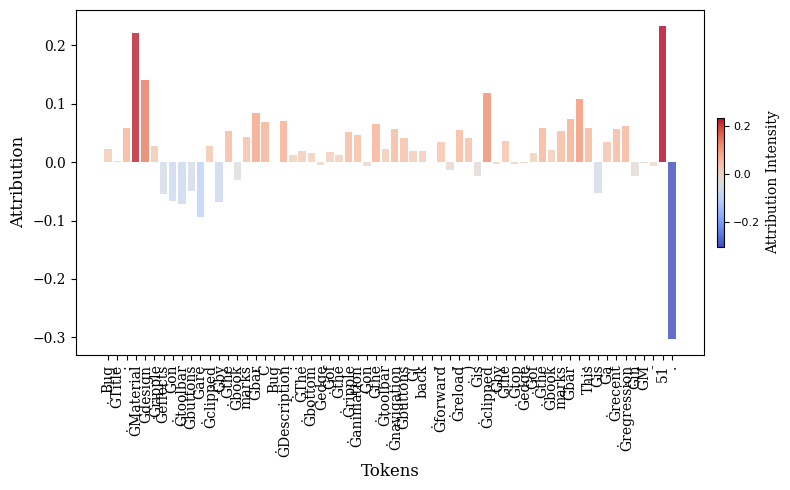

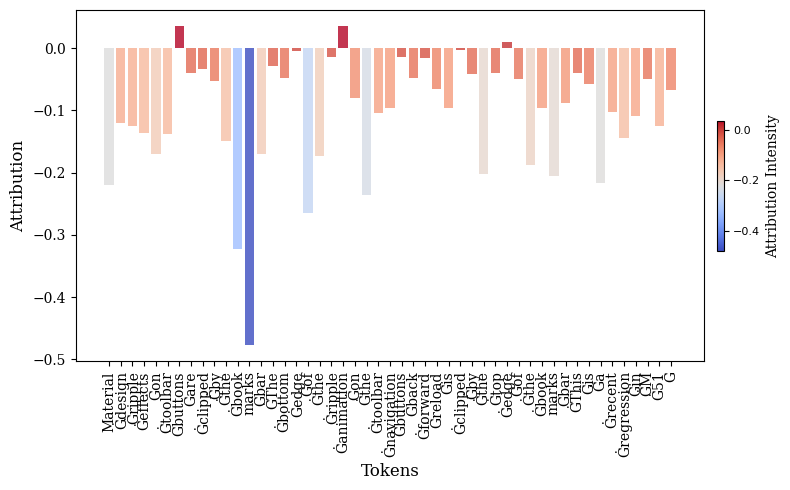

In [466]:
owner_id = 113
test_data_index = 3
owner, text, text2 = get_data(owner_id, test_data_index)
print(text)
interpret_text_triagerx(text, owner_id)
interpret_text(text2, owner_id)